<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Reduce_effects_variability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Reduce_effects_variability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bifocal Stimulation: Reducing Neural Response Variability

This notebook analyzes how bifocal (dual-region) stimulation can reduce response variability compared to single-region stimulation, and compares it to closed-loop state-dependent stimulation approaches.

In [1]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 414 (delta 29), reused 10 (delta 10), pack-reused 350 (from 2)
Receiving objects: 100% (414/414), 60.58 MiB | 28.57 MiB/s, done.
Resolving deltas: 100% (137/137), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


## 2. Compute Bifocal Effective Connectivity (BECt)

Compute bifocal effective connectivity for all subjects using trained surrogate models.


In [ ]:
# # --- 8️⃣ Main BEC(t) extraction loop ---
# pert_strength = 0.1
# BECts = {}

# for sid in subjects:
#     print(f"\n================ {sid} ================")

#     sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
#     inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
#     tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
#     mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

#     if not os.path.exists(sig_path) or not os.path.exists(mdl_path):
#         print(f"❌ Missing data or model for {sid}")
#         continue

#     # Load fMRI windows
#     Z = np.load(sig_path)             # (T, N)
#     X = np.load(inp_path)             # (M, S*N)
#     Y = np.load(tgt_path)             # (M, N)

#     # Load model
#     model = load_model(mdl_path, X, Y)
#     print("🧩 Model loaded.")

#     # Compute EC(t)
#     BEC_t = NPI.model_BECt(model, input_X=X[:500,:], target_Y=Y[:500,:], pert_strength=pert_strength, metric='l2')
#     BECts[sid] = BEC_t
#     print(f"✅ BEC(t) computed: {BEC_t.shape}")

#     # Save
#     out_path = os.path.join(ects_dir, f"{sid}_BECt.npy")
#     np.save(out_path, BEC_t)
#     print(f"💾 Saved BEC(t) → {out_path}")

#     del Z, X, Y, model, BEC_t
#     gc.collect(); torch.cuda.empty_cache()

# print("\n🎯 All subjects processed successfully.")


================ id_100206 ================
🧩 Model loaded.
✅ BEC(t) computed: (500, 450, 450)
💾 Saved BEC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100206_BECt.npy

================ id_100307 ================
🧩 Model loaded.


KeyboardInterrupt: 

In [2]:
# --- 8️⃣ Main BEC(t) extraction loop ---
pert_strength = 0.1
BECts = {}

# --- 9️⃣ Load previously saved BECt files ---
print("Loading previously computed BECt files...")
print(f"Looking in: {ects_dir}\n")

BECts_loaded = {}
for fn in os.listdir(ects_dir):
    if fn.endswith("_BECt.npy"):
        sid = fn.replace("_BECt.npy", "")
        path = os.path.join(ects_dir, fn)
        try:
            BEC_t = np.load(path)
            BECts_loaded[sid] = BEC_t
            print(f"✓ Loaded {sid}: shape {BEC_t.shape}")
        except Exception as e:
            print(f"✗ Failed to load {sid}: {e}")

# Merge with newly computed (newly computed take precedence if duplicate)
BECts.update(BECts_loaded)

print(f"\n📊 Total BECt matrices available: {len(BECts)}")
print(f"   From computation: {len([k for k in BECts.keys() if k in locals().get('subjects', [])])}")
print(f"   From disk: {len(BECts_loaded)}")
if len(BECts) == 0:
    print("⚠️  No BECt data available. Run computation cell above or check ects_dir path.")

Loading previously computed BECt files...
Looking in: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP

✓ Loaded id_100206: shape (500, 450, 450)

📊 Total BECt matrices available: 1
   From computation: 1
   From disk: 1


In [3]:
sid=list(BECts.keys())[0]
n=400
sid

'id_100206'

## 3. Functional Connectivity

FC for first participant

In [4]:
# Single subject plots
sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)
S=3 #number of steps
N=Z.shape[1] #number of regions
Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=4600, noise_strength=0.1)

# Empirical vs simulated time series, FC

test_dur=3000

emp=Z[-test_dur:,:]
sim=Zsim[-test_dur:,:]

FC_emp=np.corrcoef(emp.T)
FC_sim=np.corrcoef(sim.T)

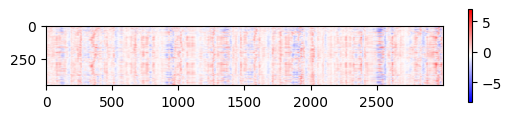

In [5]:
plt.imshow(sim.T,cmap='bwr')
plt.colorbar(shrink=0.25)

In [6]:
sim.shape

(3000, 450)

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------
# 1) Estimate baseline sensitivity for each region
# ----------------------------------------------------
def compute_baseline_sensitivity(sim, tau=1, alpha=1.0):
    """
    Estimate how strongly each region's future depends on the global baseline state.

    Parameters
    ----------
    sim : array (T, N)
        Time x region matrix (z-scored).
    tau : int
        Time lag.
    alpha : float
        Ridge regularization strength.

    Returns
    -------
    sensitivity : array (N,)
        Baseline sensitivity per region.
    """
    T, N = sim.shape
    X_past = sim[:-tau]
    X_future = sim[tau:]

    # Global baseline state (mean activity at each time)
    baseline = X_past.mean(axis=1, keepdims=True)

    sensitivity = np.zeros(N)

    for i in range(N):
        y = X_future[:, i]

        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(baseline, y)

        # Absolute gain = sensitivity to baseline
        sensitivity[i] = np.abs(model.coef_[0])

    return sensitivity


# ----------------------------------------------------
# 2) Build pairwise complementarity matrix
# ----------------------------------------------------
def compute_complementarity_matrix(sensitivity):
    """
    Pairwise complementarity = absolute difference in sensitivities.

    Parameters
    ----------
    sensitivity : array (N,)

    Returns
    -------
    C : array (N, N)
        Complementarity matrix.
    """
    N = len(sensitivity)
    C = np.zeros((N, N))

    for i in range(N):
        for j in range(i + 1, N):
            C[i, j] = C[j, i] = np.abs(sensitivity[i] - sensitivity[j])

    return C


# ----------------------------------------------------
# 3) Run everything
# ----------------------------------------------------
# sim is assumed to already exist: shape (T, N)

tau = 1
baseline_sensitivity = compute_baseline_sensitivity(emp, tau=tau, alpha=1.0)
Complementarity = compute_complementarity_matrix(baseline_sensitivity)

print("Baseline sensitivity shape:", baseline_sensitivity.shape)
print("Complementarity matrix shape:", Complementarity.shape)


Baseline sensitivity shape: (450,)
Complementarity matrix shape: (450, 450)


In [7]:
from scipy.stats import pearsonr

def upper_tri_vals(M):
    mask = np.triu(np.ones_like(M, dtype=bool), k=1)
    return M[mask]

def corr_with_target(edge_metric, target_matrix):
    x = upper_tri_vals(edge_metric)
    y = upper_tri_vals(target_matrix)
    r, p = pearsonr(x, y)
    return r, p


In [8]:

import pandas as pd
import pickle
dataframe_dir  = os.path.join(data_dir, "dataframe")
path = os.path.join(dataframe_dir, "dataframe.pkl")
with open(path, "rb") as f:
    df = pickle.load(f)

In [ ]:
df

sid  roi  responsiveness  predictability  principal_gradient  \
0     id_100206    0        0.000436       -0.494759           -0.049444   
1     id_100206    1        0.000615       -0.401189            0.010966   
2     id_100206    2        0.000378       -0.471682           -0.021721   
3     id_100206    3        0.000418       -0.361711           -0.060374   
4     id_100206    4        0.000393       -0.433977           -0.051529   
...         ...  ...             ...             ...                 ...   
3995  id_102311  395        0.000343       -0.261130            0.081363   
3996  id_102311  396        0.000278       -0.410756            0.064408   
3997  id_102311  397        0.000322       -0.302693            0.045430   
3998  id_102311  398        0.000249       -0.255351            0.117230   
3999  id_102311  399        0.000244       -0.217504           -0.032585   

      5HT4_sb20_hc59_beliveau.csv  5HT6_gsk_hc30_radhakrishnan.csv  \
0                        1.973089                         0.327083   
1                        2.145067                         0.385849   
2                        1.868203                         0.369909   
3                        2.031370                         0.403947   
4                        1.895362                         0.405218   
...                           ...                              ...   
3995                     2.458207                         0.633266   
3996                     2.521605                         0.426852   
3997                     2.532997                         0.324955   
3998                     2.423518                         0.475818   
3999                     2.330847                         0.574120   

      A4B2_flubatine_hc30_hillmer.csv  D1_SCH23390_hc13_kaller.csv  \
0                            9.928139                    19.084266   
1                            9.480640                    18.276535   
2                           10.301394                    14.429312   
3                           10.027803                    17.679196   
4                           10.131259                    15.705146   
...                               ...                          ...   
3995                        10.650736                    20.157903   
3996                        10.556403                    21.477304   
3997                        10.753576                    21.422412   
3998                        10.452027                    17.906608   
3999                        10.736755                    18.884560   

      H3_cban_hc8_gallezot.csv  ...        DAT        GABA         MU  \
0                    16.457528  ...  15.261758  430.890511  11.665264   
1                    16.161533  ...  16.367297  423.358869  10.408719   
2                    16.414764  ...  14.629332  431.931700   8.635947   
3                    15.466934  ...  14.750274  474.282215   6.721986   
4                    15.586376  ...  14.986570  467.329135   3.834995   
...                        ...  ...        ...         ...        ...   
3995                 19.536787  ...  14.548252  501.267849  10.417171   
3996                 16.774457  ...  15.349130  476.006128  13.601736   
3997                 19.354674  ...  15.493046  475.749008  15.872875   
3998                 17.443165  ...  15.080128  409.934983  11.307268   
3999                 19.929520  ...  14.245218  450.623382  13.021978   

           NAT      Vacht    mGluR5  rsn_name  rsn_id   SC_strength  \
0     6.298222  10.073338  2.305908       Vis       1  37161.546875   
1     6.395766  10.738670  2.398924       Vis       1  50868.304688   
2     5.998399  10.108295  2.244107       Vis       1  32609.529297   
3     5.033700  10.181794  2.268144       Vis       1  43413.921875   
4     5.226217  10.061389  2.156322       Vis       1  38693.851562   
...        ...        ...       ...       ...     ...           ...   
3995  9.183700  10.924810  2.634031   Defau

In [19]:
import numpy as np
import pandas as pd

# ----------------------------------------------------
# 1) Select subject
# ----------------------------------------------------

df_sub = df[df["sid"] == sid].copy()

# Safety check
df_sub = df_sub.sort_values("roi")
assert df_sub["roi"].is_monotonic_increasing, "ROIs must be ordered"

# ----------------------------------------------------
# 2) Extract node-wise vectors
# ----------------------------------------------------
resp = df_sub["responsiveness"].values    # shape (N,)
pred = df_sub["predictability"].values    # shape (N,)

N = len(resp)
print(f"Subject {sid} with {N} ROIs")

# ----------------------------------------------------
# 3) Compute complementarity matrices
# ----------------------------------------------------
# Broadcasting trick:
# |x_i - x_j| for all i,j
RespComplementarity = np.abs(resp[:, None] - resp[None, :])#/np.abs(resp[:, None] + resp[None, :])
PredComplementarity = np.abs(pred[:, None] - pred[None, :])#/np.abs(pred[:, None] + pred[None, :])

# Zero diagonal (optional but usually cleaner)
np.fill_diagonal(RespComplementarity, 0.0)
np.fill_diagonal(PredComplementarity, 0.0)

print("RespComplementarity shape:", RespComplementarity.shape)
print("PredComplementarity shape:", PredComplementarity.shape)


Subject id_100206 with 400 ROIs
RespComplementarity shape: (400, 400)
PredComplementarity shape: (400, 400)


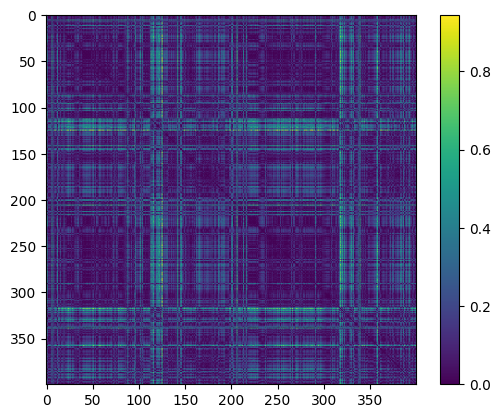

In [23]:
plt.imshow(((1-np.abs(FC_sim))[-n:,-n:]*RespComplementarity/np.max(RespComplementarity)).T)
plt.colorbar()

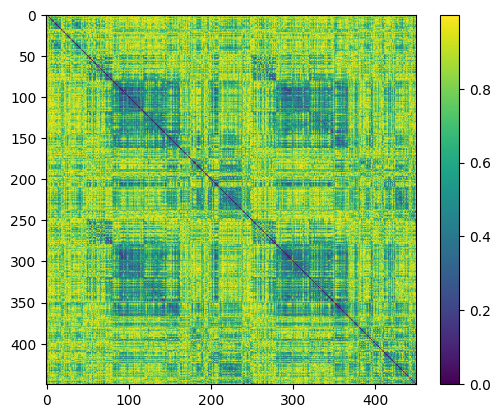

In [ ]:
plt.imshow((1-np.abs(FC_sim)).T)
plt.colorbar()

In [ ]:
# Save
#     out_path = os.path.join(ects_dir, f"{sid}_BECt.npy")
#     np.save(out_path, BEC_t)
#     print(f"💾 Saved BEC(t) → {out_path}")

## 4. Visualize Bifocal Variability Reduction

Heatmaps showing which region pairs most effectively reduce neural response variability.


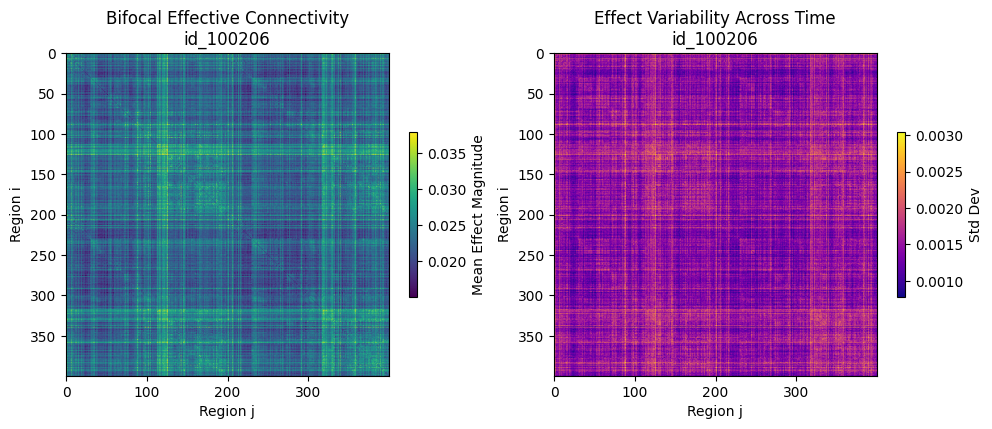

In [10]:
if len(BECts) > 0:
    # Analyze first subject for visualization
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]
    #analysis = analyze_bifocal_variability_reduction(BEC_t)
    mean_bec = np.mean(BEC_t, axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Heatmap 1: Mean bifocal effective connectivity
    im1 = axes[0].imshow(mean_bec[-n:,-n:], cmap='viridis')
    axes[0].set_title(f'Bifocal Effective Connectivity\n{first_sid}')
    axes[0].set_xlabel('Region j')
    axes[0].set_ylabel('Region i')
    plt.colorbar(im1, ax=axes[0], label='Mean Effect Magnitude',shrink=0.35)

    # Heatmap 2: Temporal variability (std across time)
    std_bec = np.std(BEC_t, axis=0)
    im2 = axes[1].imshow(std_bec[-n:,-n:], cmap='plasma')
    axes[1].set_title(f'Effect Variability Across Time\n{first_sid}')
    axes[1].set_xlabel('Region j')
    axes[1].set_ylabel('Region i')
    plt.colorbar(im2, ax=axes[1], label='Std Dev',shrink=0.35)

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'bifocal_heatmaps.png'), dpi=150, bbox_inches='tight')
    plt.show()

    #print(f"\n✓ Heatmaps generated for {first_sid}")
    #print(f"  Mean bifocal effect: {analysis['global_mean_effect']:.4f} ± {analysis['global_std_effect']:.4f}")
    #print(f"\n  Top 5 region pairs by bifocal effect:")
    #for rank, pair in enumerate(analysis['top_pairs'][:5], 1):
    #    print(f"    {rank}. Regions {pair['regions']}: {pair['mean_effect']:.4f} ± {pair['std_effect']:.4f}")
else:
    print("⚠️ No BECt data computed. Run cell above first.")


In [11]:
N

450

NameError: name 'RespComplementarity' is not defined

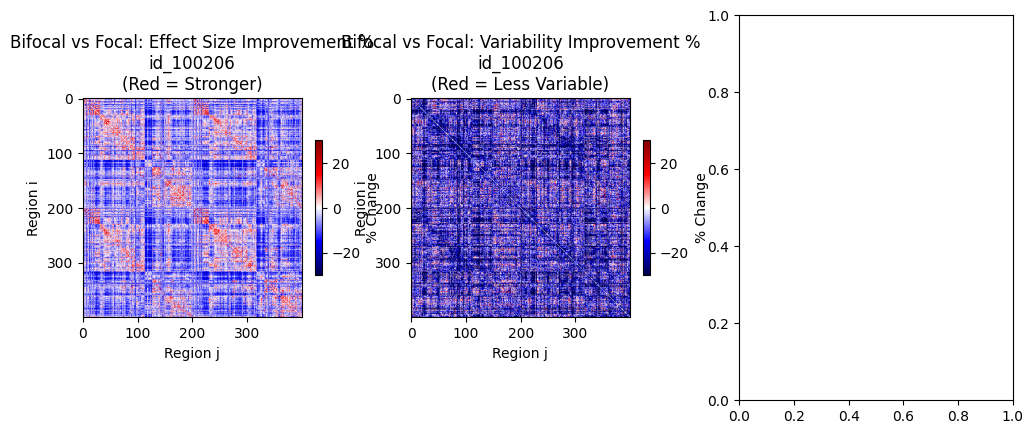

In [12]:
if len(BECts) > 0:
    # Compare bifocal (ij) to focal (ii, jj) stimulation
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]
    M, N, _ = BEC_t.shape

    # Extract statistics for focal and bifocal effects
    #focal_mean = np.array([np.mean(BEC_t[:, i, i]) for i in range(N)])  # (N,)
    #focal_std = np.array([np.std(BEC_t[:, i, i]) for i in range(N)])    # (N,)
    bifocal_mean = np.mean(BEC_t, axis=0)  # (N, N)
    bifocal_std = np.std(BEC_t, axis=0)    # (N, N)

    # Create improvement matrices
    var_improvement = np.zeros((N, N))      # (N, N)
    effect_improvement = np.zeros((N, N))   # (N, N)

    for i in range(N):
        for j in range(N):
            if i != j:
                # Variability improvement: -1 * (AB - min(A,B)) / min(A,B) * 100
                # Positive = better (less variable)
                var_A = bifocal_std[i, i]#focal_std[i]
                var_B = bifocal_std[j, j]#focal_std[j]
                var_AB = bifocal_std[i, j]
                var_min = min(var_A, var_B)

                if var_min > 1e-10:
                    var_improvement[i, j] = -1 * (var_AB - var_min) / var_min * 100
                else:
                    var_improvement[i, j] = np.nan

                # Effect size improvement: (AB - max(A,B)) / max(A,B) * 100
                # Positive = better (stronger)
                effect_A = np.abs(bifocal_mean[i, i])
                effect_B = np.abs(bifocal_mean[j, j])
                effect_AB = np.abs(bifocal_mean[i, j])
                effect_max = max(effect_A, effect_B)

                if effect_max > 1e-10:
                    effect_improvement[i, j] = (effect_AB - effect_max) / effect_max * 100
                else:
                    effect_improvement[i, j] = np.nan

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Heatmap 1: Effect size improvement (positive = better)
    vmax_eff = 30#np.nanmax(np.abs(effect_improvement))
    im1 = axes[0].imshow(effect_improvement[-n:,-n:], cmap='seismic',
                         vmin=-vmax_eff, vmax=vmax_eff)
    axes[0].set_title(f'Bifocal vs Focal: Effect Size Improvement %\n{first_sid}\n(Red = Stronger)')
    axes[0].set_xlabel('Region j')
    axes[0].set_ylabel('Region i')
    cbar1 = plt.colorbar(im1, ax=axes[0], label='% Change',shrink=0.35)

    # Heatmap 2: Variability improvement (negative = better)
    vmax_var = 30#np.nanmax(np.abs(var_improvement))
    im2 = axes[1].imshow(var_improvement[-n:,-n:], cmap='seismic',
                         vmin=-vmax_var, vmax=vmax_var)
    axes[1].set_title(f'Bifocal vs Focal: Variability Improvement %\n{first_sid}\n(Red = Less Variable)')
    axes[1].set_xlabel('Region j')
    axes[1].set_ylabel('Region i')
    cbar2 = plt.colorbar(im2, ax=axes[1], label='% Change',shrink=0.35)

    # Heatmap 3: Relative effect size improvement (positive = better)
    #var_improvement / effect_improvement

    #vmax_eff = 1
    im3 = axes[2].imshow(RespComplementarity[-n:,-n:], cmap='seismic')
    axes[2].set_title(f'FC model')
    axes[2].set_xlabel('Region j')
    axes[2].set_ylabel('Region i')
    cbar3 = plt.colorbar(im3, ax=axes[2], label='% Change',shrink=0.35)

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'bifocal_vs_focal_improvement.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Focal vs Bifocal improvement heatmaps generated for {first_sid}")
    print(f"  Left: Variability improvement (positive = bifocal is more stable than focal)")
    print(f"  Right: Effect size improvement (positive = bifocal is stronger than focal)")
else:
    print("⚠️ No BECt data available.")

In [13]:
# # Structural Connectivity

# !pip -q install git+https://github.com/MICA-MNI/ENIGMA.git

# from enigmatoolbox.datasets import load_sc

# sc_ctx, sc_labels, sc_sctx, sctx_labels = load_sc(parcellation="schaefer_400")

# # sc_ctx is 400x400 cortico-cortical SC
# print(sc_ctx.shape)
# print(sc_labels[0], sc_labels[-1])


In [14]:
var_gain=var_improvement[-n:,-n:]

In [17]:
results = []
r, p = corr_with_target((1-FC_sim**2)[-n:,-n:], var_improvement[-n:,-n:])  # VarRed is your AB variability reduction matrix
results.append((r, p))
results

[(np.float64(0.12456287252623502), np.float64(2.450330663046695e-273))]

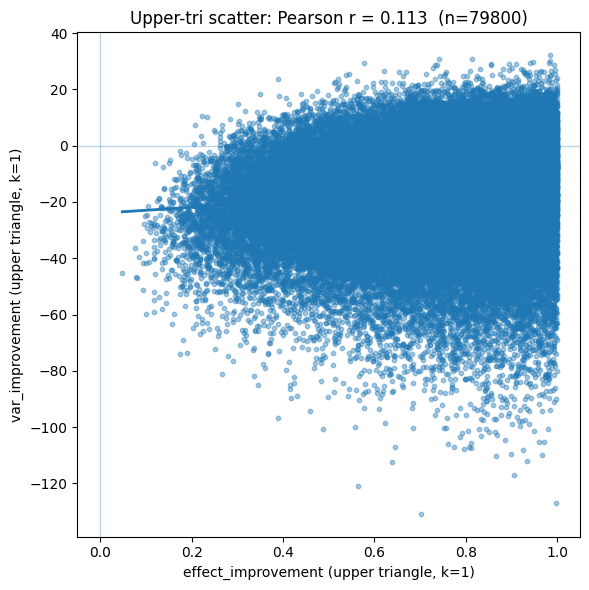

Pearson r = 0.113469
Regression: y = 10.3899 * x + -23.9931


In [32]:
import numpy as np
import matplotlib.pyplot as plt

N=400
mat=((1-np.abs(FC_sim))[-n:,-n:])

# 1) Pull upper-triangular entries (exclude diagonal)
iu = np.triu_indices_from(np.zeros((N,N)), k=1)

x = mat[iu].astype(float)
y = var_improvement[-n:,-n:][iu].astype(float)

# 2) Drop NaNs/Infs (and anything invalid)
m = np.isfinite(x) & np.isfinite(y)
x = x[m]
y = y[m]

# 3) Pearson r
r = np.corrcoef(x, y)[0, 1]

# 4) Regression line: y = slope*x + intercept
slope, intercept = np.polyfit(x, y, 1)

# 5) Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, s=10, alpha=0.4)

# regression line over x-range
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, slope * xx + intercept, linewidth=2)

ax.set_xlabel("effect_improvement (upper triangle, k=1)")
ax.set_ylabel("var_improvement (upper triangle, k=1)")
ax.set_title(f"Upper-tri scatter: Pearson r = {r:.3f}  (n={len(x)})")

ax.axhline(0, linewidth=1, alpha=0.3)
ax.axvline(0, linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pearson r = {r:.6f}")
print(f"Regression: y = {slope:.6g} * x + {intercept:.6g}")


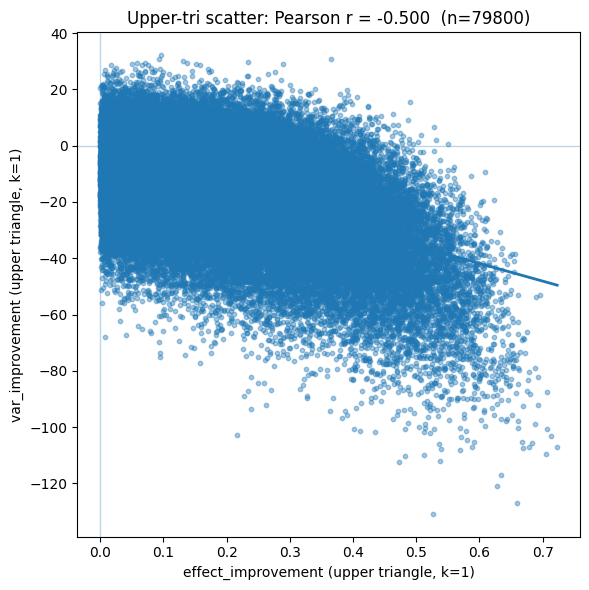

Pearson r = -0.500346
Regression: y = -62.7136 * x + -4.21365


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N=400

# 1) Pull upper-triangular entries (exclude diagonal)
iu = np.triu_indices_from(np.zeros((N,N)), k=1)

x = RespComplementarity[-n:,-n:][iu].astype(float)
y = var_improvement[-n:,-n:][iu].astype(float)

# 2) Drop NaNs/Infs (and anything invalid)
m = np.isfinite(x) & np.isfinite(y)
x = x[m]
y = y[m]

# 3) Pearson r
r = np.corrcoef(x, y)[0, 1]

# 4) Regression line: y = slope*x + intercept
slope, intercept = np.polyfit(x, y, 1)

# 5) Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, s=10, alpha=0.4)

# regression line over x-range
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, slope * xx + intercept, linewidth=2)

ax.set_xlabel("effect_improvement (upper triangle, k=1)")
ax.set_ylabel("var_improvement (upper triangle, k=1)")
ax.set_title(f"Upper-tri scatter: Pearson r = {r:.3f}  (n={len(x)})")

ax.axhline(0, linewidth=1, alpha=0.3)
ax.axvline(0, linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pearson r = {r:.6f}")
print(f"Regression: y = {slope:.6g} * x + {intercept:.6g}")


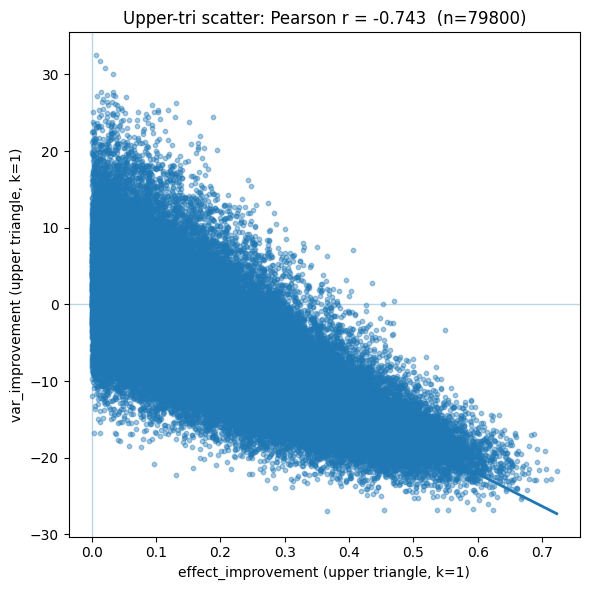

Pearson r = -0.742729
Regression: y = -42.3593 * x + 3.33828


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N=400

# 1) Pull upper-triangular entries (exclude diagonal)
iu = np.triu_indices_from(np.zeros((N,N)), k=1)

x = RespComplementarity[-n:,-n:][iu].astype(float)
y = effect_improvement[-n:,-n:][iu].astype(float)

# 2) Drop NaNs/Infs (and anything invalid)
m = np.isfinite(x) & np.isfinite(y)
x = x[m]
y = y[m]

# 3) Pearson r
r = np.corrcoef(x, y)[0, 1]

# 4) Regression line: y = slope*x + intercept
slope, intercept = np.polyfit(x, y, 1)

# 5) Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, s=10, alpha=0.4)

# regression line over x-range
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, slope * xx + intercept, linewidth=2)

ax.set_xlabel("effect_improvement (upper triangle, k=1)")
ax.set_ylabel("var_improvement (upper triangle, k=1)")
ax.set_title(f"Upper-tri scatter: Pearson r = {r:.3f}  (n={len(x)})")

ax.axhline(0, linewidth=1, alpha=0.3)
ax.axvline(0, linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pearson r = {r:.6f}")
print(f"Regression: y = {slope:.6g} * x + {intercept:.6g}")

In [ ]:
# from google.colab import files
# files.upload()
# import numpy as np
# dist = np.load("dist_400.npy")

In [ ]:
from scipy import stats
stats.spearmanr(x,y)

SignificanceResult(statistic=np.float64(-0.19300861814916356), pvalue=np.float64(0.0))

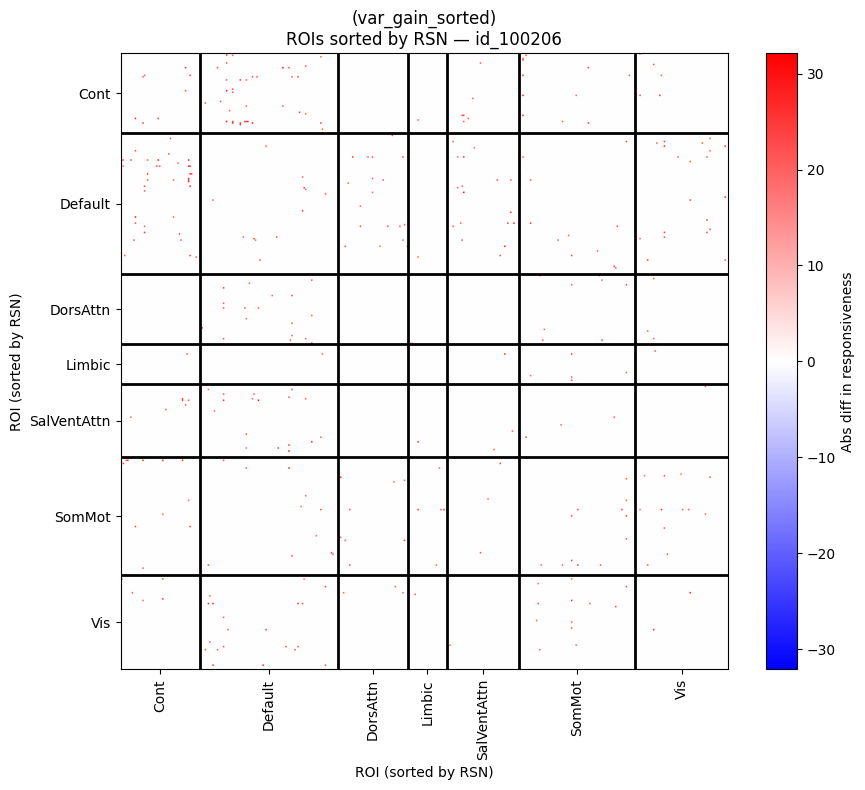

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Inputs you already have:
# =========================
# df: columns include ["sid", "roi", "responsiveness", "rsn_name", ...]
# var_gain: ROI×ROI matrix for that same subject (already restricted to n cortical ROIs)
# sid: subject id string, e.g. "id_100206"

sid = "id_100206"

# ----------------------------------------------------
# 1) Slice subject + align ROIs
# ----------------------------------------------------
df_sub = df.loc[df["sid"] == sid, ["roi", "responsiveness", "rsn_name"]].copy()
df_sub = df_sub.dropna(subset=["roi", "responsiveness", "rsn_name"])
df_sub["roi"] = df_sub["roi"].astype(int)

# Number of cortical regions
n = var_gain.shape[0]
assert var_gain.shape == (n, n), f"var_gain must be (n,n); got {var_gain.shape}"
assert df_sub["roi"].max() < n, "df ROI indices exceed var_gain size"

# Keep only ROIs present in df_sub and within bounds
df_sub = df_sub[df_sub["roi"].between(0, n - 1)]

# ----------------------------------------------------
# 2) Build responsiveness vector (length n)
# ----------------------------------------------------
resp = np.full(n, np.nan, dtype=float)
resp[df_sub["roi"].values] = df_sub["responsiveness"].values

if np.isnan(resp).any():
    missing = np.where(np.isnan(resp))[0]
    print(f"[WARN] {len(missing)} ROIs missing responsiveness for {sid}. "
          "They will be excluded.")
    keep = ~np.isnan(resp)
else:
    keep = np.ones(n, dtype=bool)

roi_keep = np.where(keep)[0]
resp_keep = resp[keep]

# ----------------------------------------------------
# 3) rRespComplementarity (ROI×ROI)
# ----------------------------------------------------
rRespComplementarity = np.abs(resp_keep[:, None] - resp_keep[None, :])
np.fill_diagonal(rRespComplementarity, 0.0)

# Align var_gain to kept ROIs
var_gain_keep = var_gain[np.ix_(roi_keep, roi_keep)]

# ----------------------------------------------------
# 4) Sort ROIs by RSN
# ----------------------------------------------------
roi_to_rsn = (
    df_sub.set_index("roi")["rsn_name"]
    .reindex(roi_keep)
    .astype(str)
)

order_df = pd.DataFrame({
    "roi": roi_keep,
    "rsn": roi_to_rsn.values
})

order_df = order_df.sort_values(["rsn", "roi"], kind="mergesort")
order = order_df["roi"].to_numpy()

# Map ROI → index in kept arrays
pos_in_keep = {roi: idx for idx, roi in enumerate(roi_keep)}
order_idx = np.array([pos_in_keep[roi] for roi in order], dtype=int)

# Reorder matrices
rRespComp_sorted = rRespComplementarity[np.ix_(order_idx, order_idx)]
var_gain_sorted = var_gain_keep[np.ix_(order_idx, order_idx)]
rsn_sorted = order_df["rsn"].to_numpy()

# RSN block info for plotting
rsn_series = pd.Series(rsn_sorted)
rsn_changes = np.where(rsn_series.values[:-1] != rsn_series.values[1:])[0] + 1
rsn_groups = rsn_series.groupby(rsn_series).size()
rsn_names = rsn_groups.index.tolist()
rsn_sizes = rsn_groups.values
rsn_starts = np.concatenate([[0], np.cumsum(rsn_sizes)[:-1]])
rsn_centers = rsn_starts + (rsn_sizes - 1) / 2.0

# ----------------------------------------------------
# 5) Plot var_gain_sorted sorted by RSN
# ----------------------------------------------------
plt.figure(figsize=(9, 8))
vmax=np.max(var_gain_sorted)
im = plt.imshow(np.where(var_gain_sorted>20,var_gain_sorted,0), cmap='bwr',aspect="auto",vmax=vmax,vmin=-vmax)
plt.title(f"(var_gain_sorted)\nROIs sorted by RSN — {sid}") #|Resp(i) − Resp(j)|
plt.xlabel("ROI (sorted by RSN)")
plt.ylabel("ROI (sorted by RSN)")
plt.colorbar(im, label="Abs diff in responsiveness")

for b in rsn_changes:
    plt.axhline(b - 0.5, linewidth=2,c='k')
    plt.axvline(b - 0.5, linewidth=2,c='k')

plt.xticks(rsn_centers, rsn_names, rotation=90)
plt.yticks(rsn_centers, rsn_names)
plt.tight_layout()
plt.show()


In [ ]:
np.where(var_gain>25)

(array([ 11,  15,  16,  18,  18,  18,  33,  33,  33,  33,  35,  38,  44,
         65,  65,  65,  69,  77, 101, 101, 119, 119, 130, 135, 135, 140,
        141, 143, 153, 156, 156, 163, 163, 165, 165, 169, 169, 174, 174,
        177, 179, 182, 183, 186, 189, 191, 199, 204, 204, 227, 227, 231,
        238, 247, 255, 263, 290, 292, 305, 308, 308, 310, 312, 314, 328,
        333, 336, 336, 349, 351, 353, 353, 353, 353, 354, 354, 354, 354,
        363, 367, 367, 367, 373, 373, 377, 382, 382, 395]),
 array([204, 336,  65, 153, 156, 373, 130, 140, 336, 349, 305, 367,  69,
         16, 119, 328,  44, 163, 163, 186,  65, 308,  33, 351, 363,  33,
        373, 174,  18,  18, 227,  77, 101, 333, 353, 353, 354, 143, 354,
        353, 353, 354, 377, 101, 227, 204, 312,  11, 191, 156, 189, 263,
        354, 290, 395, 231, 247, 382,  35, 119, 382, 367, 199, 367,  65,
        165,  15,  33,  33, 135, 165, 169, 177, 179, 169, 174, 182, 238,
        135,  38, 310, 314,  18, 141, 183, 292, 308, 255]))


================ id_100206 ================
  Selected 25 timepoints from 500 total
  Random: 25 points
  Low energy: mean E = 449.8931
  High energy: mean E = 7346.8812


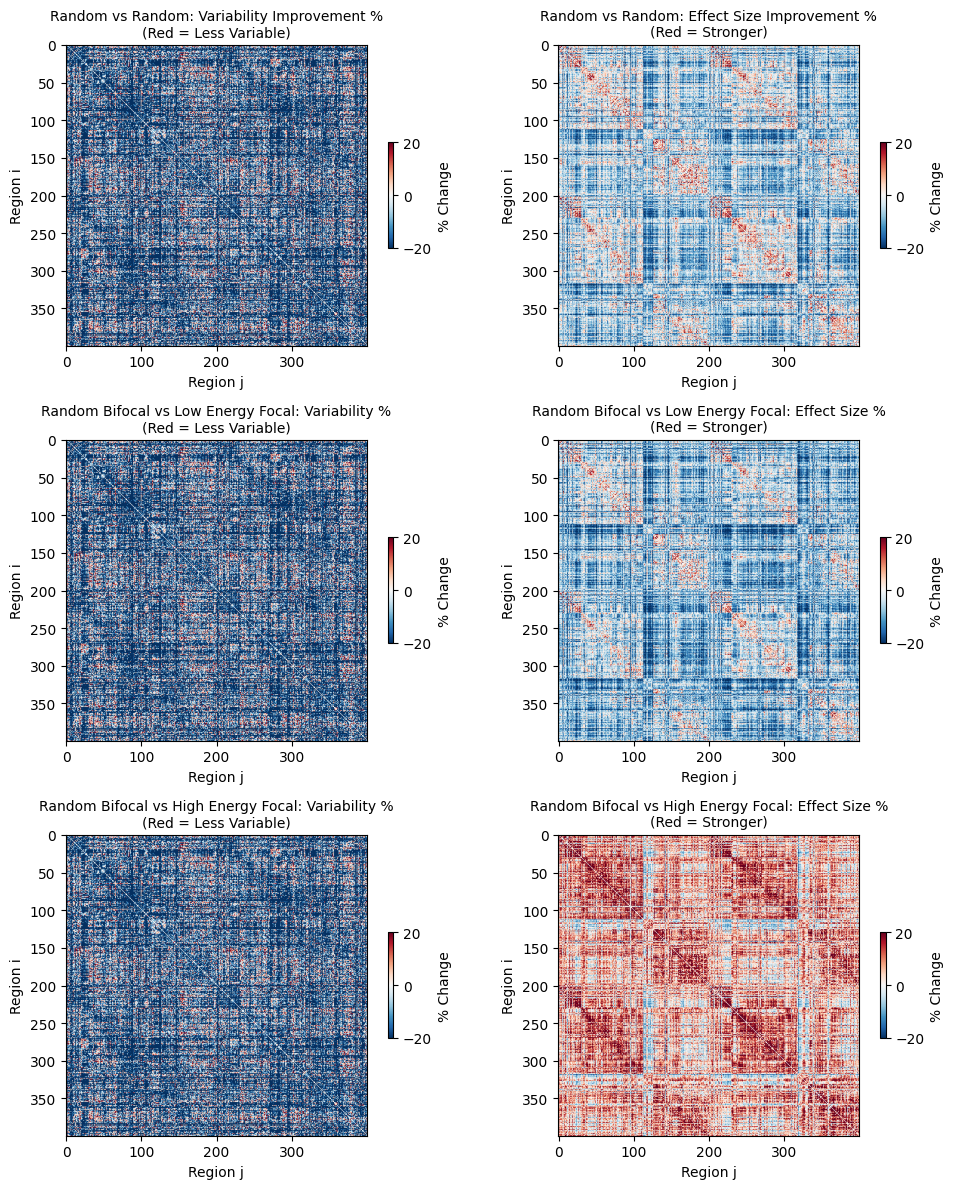


✓ Energy-dependent comparison heatmaps generated for id_100206
  Row 1: Random bifocal (10%) vs Random focal (10%)
  Row 2: Random bifocal (10%) vs Low energy focal (10%)
  Row 3: Random bifocal (10%) vs High energy focal (10%)


In [ ]:
# Fraction of timepoints to keep (10%)
frac = 0.05

if len(BECts) > 0:
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]

    print(f"\n================ {first_sid} ================")

    inp_path = os.path.join(preproc_dir, f"{first_sid}_inputs.npy")
    X = np.load(inp_path)  # (M, S*N)

    M, N, _ = BEC_t.shape
    S = X.shape[1] // N

    # --- Baseline energy
    x_t = X[:M, :]
    E_t = np.sum(x_t**2, axis=1)
    n_sel = int(frac * M)
    sorted_idx = np.argsort(E_t)
    low_idx = sorted_idx[:n_sel]
    high_idx = sorted_idx[-n_sel:]
    rngx = np.random.default_rng(seed=42)
    rand_idx = rngx.choice(M, size=n_sel, replace=False)
    rngy = np.random.default_rng(seed=4)
    rand_idy = rngy.choice(M, size=n_sel, replace=False)

    print(f"  Selected {n_sel} timepoints from {M} total")
    print(f"  Random: {len(rand_idx)} points")
    print(f"  Low energy: mean E = {np.mean(E_t[low_idx]):.4f}")
    print(f"  High energy: mean E = {np.mean(E_t[high_idx]):.4f}")

    # Function to compute improvements for a given time selection
    def compute_improvements(BEC_t, time_idx, time_idy, label=""):
        """Compute bifocal vs focal improvements for selected timepoints."""
        M, N, _ = BEC_t.shape

        # Extract at selected times
        focal_mean = np.array([np.mean(BEC_t[time_idx, i, i]) for i in range(N)])
        focal_std = np.array([np.std(BEC_t[time_idx, i, i]) for i in range(N)])
        bifocal_mean = np.mean(BEC_t[time_idy, :, :], axis=0)
        bifocal_std = np.std(BEC_t[time_idy, :, :], axis=0)

        var_improvement = np.zeros((N, N))
        effect_improvement = np.zeros((N, N))

        for i in range(N):
            for j in range(N):
                if i != j:
                    # Variability improvement
                    var_A = bifocal_std[i, i]
                    var_B = bifocal_std[j, j]
                    var_AB = bifocal_std[i, j]
                    var_min = min(var_A, var_B)

                    if var_min > 1e-10:
                        var_improvement[i, j] = -1 * (var_AB - var_min) / var_min * 100
                    else:
                        var_improvement[i, j] = np.nan

                    # Effect size improvement
                    effect_A = np.abs(focal_mean[i])
                    effect_B = np.abs(focal_mean[j])
                    effect_AB = np.abs(bifocal_mean[i, j])
                    effect_max = max(effect_A, effect_B)

                    if effect_max > 1e-10:
                        effect_improvement[i, j] = (effect_AB - effect_max) / effect_max * 100
                    else:
                        effect_improvement[i, j] = np.nan

        return var_improvement, effect_improvement

    # Compute improvements for all three focal conditions
    var_rand_rand, eff_rand_rand = compute_improvements(BEC_t, rand_idx, rand_idy, "random times")
    var_rand_low, eff_rand_low = compute_improvements(BEC_t, low_idx, rand_idy, "low energy times")
    var_rand_high, eff_rand_high = compute_improvements(BEC_t, high_idx, rand_idy, "high energy times")

    # Create 3x2 subplot figure
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))

    # Helper function to plot heatmap
    def plot_heatmap(ax, data, title, cbar_label='% Change'):
        vmax = 20#np.nanmax(np.abs(data))
        im = ax.imshow(data, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Region j')
        ax.set_ylabel('Region i')
        plt.colorbar(im, ax=ax, label=cbar_label,shrink=0.35)
        return im

    # Row 1: Random bifocal vs Random focal
    plot_heatmap(axes[0, 0], var_rand_rand[-n:,-n:],
                 f'Random vs Random: Variability Improvement %\n(Red = Less Variable)')
    plot_heatmap(axes[0, 1], eff_rand_rand[-n:,-n:],
                 f'Random vs Random: Effect Size Improvement %\n(Red = Stronger)')

    # Row 2: Random bifocal vs Low energy focal
    plot_heatmap(axes[1, 0], var_rand_low[-n:,-n:],
                 f'Random Bifocal vs Low Energy Focal: Variability %\n(Red = Less Variable)')
    plot_heatmap(axes[1, 1], eff_rand_low[-n:,-n:],
                 f'Random Bifocal vs Low Energy Focal: Effect Size %\n(Red = Stronger)')

    # Row 3: Random bifocal vs High energy focal
    plot_heatmap(axes[2, 0], var_rand_high[-n:,-n:],
                 f'Random Bifocal vs High Energy Focal: Variability %\n(Red = Less Variable)')
    plot_heatmap(axes[2, 1], eff_rand_high[-n:,-n:],
                 f'Random Bifocal vs High Energy Focal: Effect Size %\n(Red = Stronger)')

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'bifocal_vs_focal_energy_conditions.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Energy-dependent comparison heatmaps generated for {first_sid}")
    print(f"  Row 1: Random bifocal (10%) vs Random focal (10%)")
    print(f"  Row 2: Random bifocal (10%) vs Low energy focal (10%)")
    print(f"  Row 3: Random bifocal (10%) vs High energy focal (10%)")

    del X
else:
    print("⚠️ No BECt data available.")


================ FOCAL-ONLY PER-REGION ANALYSIS: id_100206 ================


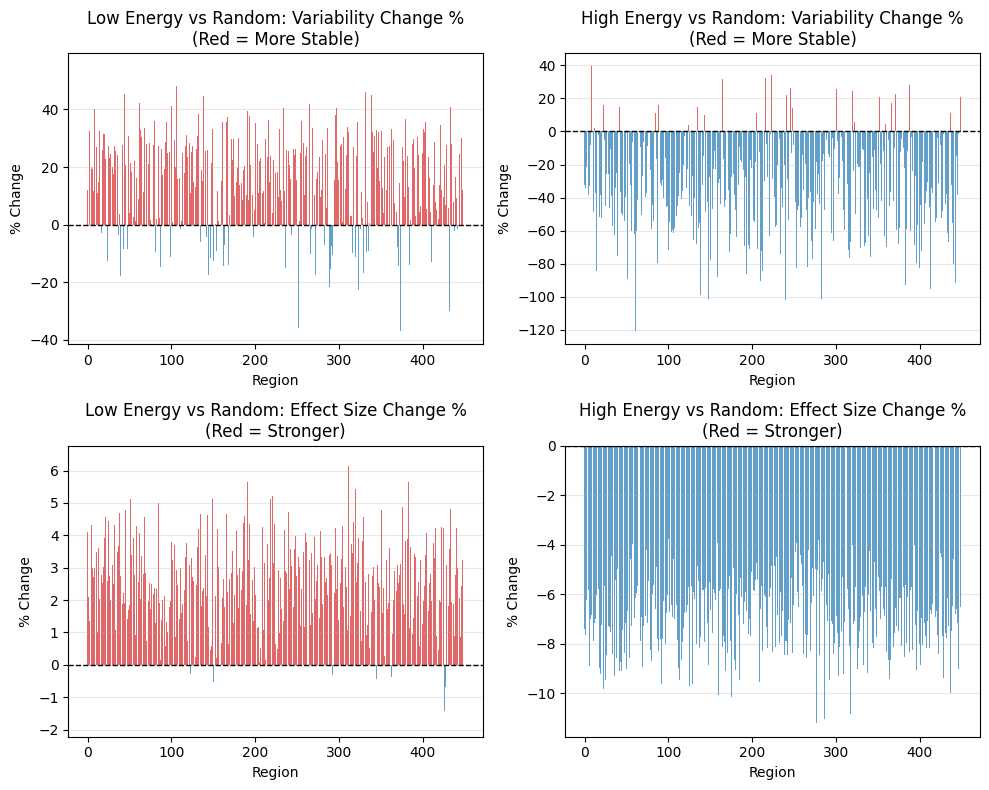

In [ ]:
# Focal-only comparison: Per-region variability and effect size
if len(BECts) > 0:
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]

    print(f"\n================ FOCAL-ONLY PER-REGION ANALYSIS: {first_sid} ================")

    M, N, _ = BEC_t.shape

    # Compute per-region metrics for each time condition
    # Effect sizes: mean of diagonal values
    effect_rand = np.array([np.mean(BEC_t[rand_idx, i, i]) for i in range(N)])
    effect_low = np.array([np.mean(BEC_t[low_idx, i, i]) for i in range(N)])
    effect_high = np.array([np.mean(BEC_t[high_idx, i, i]) for i in range(N)])

    # Variabilities: std dev of diagonal values
    var_rand = np.array([np.std(BEC_t[rand_idx, i, i]) for i in range(N)])
    var_low = np.array([np.std(BEC_t[low_idx, i, i]) for i in range(N)])
    var_high = np.array([np.std(BEC_t[high_idx, i, i]) for i in range(N)])

    # Calculate percent changes
    # Variability changes
    var_change_low = -1 * (var_low - var_rand) / (var_rand + 1e-10) * 100   # (N,)
    var_change_high = -1 * (var_high - var_rand) / (var_rand + 1e-10) * 100

    # Effect size changes
    effect_change_low = (effect_low - effect_rand) / (np.abs(effect_rand) + 1e-10) * 100
    effect_change_high = (effect_high - effect_rand) / (np.abs(effect_rand) + 1e-10) * 100

    # Create figure with 2×2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    regions = np.arange(N)

    # Plot 1: Variability change - Low energy
    axes[0, 0].bar(regions, var_change_low, color=['tab:blue' if x < 0 else 'tab:red' for x in var_change_low], alpha=0.7)
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 0].set_xlabel('Region')
    axes[0, 0].set_ylabel('% Change')
    axes[0, 0].set_title('Low Energy vs Random: Variability Change %\n(Red = More Stable)')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Variability change - High energy
    axes[0, 1].bar(regions, var_change_high, color=['tab:blue' if x < 0 else 'tab:red' for x in var_change_high], alpha=0.7)
    axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_xlabel('Region')
    axes[0, 1].set_ylabel('% Change')
    axes[0, 1].set_title('High Energy vs Random: Variability Change %\n(Red = More Stable)')
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Plot 3: Effect size change - Low energy
    axes[1, 0].bar(regions, effect_change_low, color=['tab:blue' if x < 0 else 'tab:red' for x in effect_change_low], alpha=0.7)
    axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_xlabel('Region')
    axes[1, 0].set_ylabel('% Change')
    axes[1, 0].set_title('Low Energy vs Random: Effect Size Change %\n(Red = Stronger)')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Effect size change - High energy
    axes[1, 1].bar(regions, effect_change_high, color=['tab:blue' if x < 0 else 'tab:red' for x in effect_change_high], alpha=0.7)
    axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 1].set_xlabel('Region')
    axes[1, 1].set_ylabel('% Change')
    axes[1, 1].set_title('High Energy vs Random: Effect Size Change %\n(Red = Stronger)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'focal_per_region_energy_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # # Print per-region statistics
    # print(f"\n📊 PER-REGION FOCAL COMPARISON:")
    # print(f"\n{'Region':<8} {'Var_rand':<10} {'Var_low':<10} {'Var_high':<10} {'VarChg_low%':<12} {'VarChg_high%':<12} {'Eff_rand':<10} {'Eff_low':<10} {'Eff_high':<10} {'EffChg_low%':<12} {'EffChg_high%':<12}")
    # print("-" * 130)
    # for i in range(N):
    #     print(f"{i:<8} {var_rand[i]:<10.4f} {var_low[i]:<10.4f} {var_high[i]:<10.4f} {var_change_low[i]:<12.2f} {var_change_high[i]:<12.2f} {effect_rand[i]:<10.4f} {effect_low[i]:<10.4f} {effect_high[i]:<10.4f} {effect_change_low[i]:<12.2f} {effect_change_high[i]:<12.2f}")

    # print(f"\n✓ Per-region focal energy comparison plots saved")
else:
    print("⚠️ No BECt data available.")

## 6. Summary: Bifocal Stimulation for Variability Reduction

Clinical implications and key findings from bifocal connectivity analysis.


In [ ]:
# OTHER FC METRICS

In [ ]:
# # ============================================================
# # Pairwise ΦID Synergy/Redundancy matrices from sim (T x N)
# # using OmegaID in Google Colab
# #
# # INPUT:
# #   sim : np.ndarray of shape (T, N)  (time x ROIs), ideally z-scored
# #
# # OUTPUT:
# #   Syn : (N, N) synergy matrix  (OmegaID atom 'sts')
# #   Red : (N, N) redundancy matrix (OmegaID atom 'rtr')
# #
# # NOTES:
# # - Uses threading backend (more stable in Colab than multiprocessing).
# # - Auto-detects whether OmegaID atoms are scalar/per-time/per-component,
# #   and chooses a reducer accordingly (mean vs sum vs identity).
# # - Includes an optional validation: sum(atoms) ≈ TDMI (Gaussian MI past↔future).
# # ============================================================

# # ---------- 0) Install deps (Colab) ----------
# !pip -q install omegaid joblib tqdm numpy scipy

# # ---------- 1) Imports ----------
# import numpy as np
# from joblib import Parallel, delayed
# from tqdm.auto import tqdm

# from omegaid.core.decomposition import calc_phiid_multivariate


# # ---------- 2) Basic checks ----------
# def _check_sim(sim: np.ndarray):
#     sim = np.asarray(sim, dtype=float)
#     if sim.ndim != 2:
#         raise ValueError(f"`sim` must be 2D (T,N). Got shape={sim.shape}")
#     T, N = sim.shape
#     if T < 3 or N < 2:
#         raise ValueError(f"`sim` too small. Got T={T}, N={N}")
#     return sim


# # ---------- 3) Reducer auto-detection ----------
# def _choose_reducer_from_atoms(atoms, T: int, tau: int, key="sts", verbose=True):
#     """
#     Decide how to turn atoms[key] into a scalar:
#       - scalar -> identity
#       - length == T - tau -> mean over time
#       - otherwise -> sum (assume per-component/features)
#     """
#     arr = np.asarray(atoms[key]).squeeze()
#     expected_timepoints = T - tau

#     if verbose:
#         print(f"[INFO] Atom '{key}' raw shape: {np.asarray(atoms[key]).shape}")
#         print(f"[INFO] Expected per-timepoint length: {expected_timepoints} (T={T}, tau={tau})")

#     if arr.ndim == 0:
#         if verbose:
#             print("[INFO] Atoms are scalars -> reducer = identity")
#         return lambda x: float(np.asarray(x).squeeze())
#     if arr.ndim == 1 and arr.shape[0] == expected_timepoints:
#         if verbose:
#             print("[INFO] Atoms are per-timepoint -> reducer = mean")
#         return lambda x: float(np.mean(np.asarray(x).squeeze()))
#     if verbose:
#         print("[INFO] Atoms look per-component/features -> reducer = sum")
#     return lambda x: float(np.sum(np.asarray(x).squeeze()))


# # ---------- 4) Optional validation: sum(atoms) ≈ TDMI ----------
# def _gaussian_mi(X, Y):
#     """
#     Gaussian mutual information I(X;Y) in bits.
#     X: (dx, T_eff), Y: (dy, T_eff)
#     """
#     X = np.asarray(X, dtype=float)
#     Y = np.asarray(Y, dtype=float)
#     Z = np.vstack([X, Y])

#     C = np.cov(Z, bias=False)
#     dx = X.shape[0]

#     Cx = C[:dx, :dx]
#     Cy = C[dx:, dx:]
#     det = np.linalg.det

#     # numeric safety
#     eps = 1e-12
#     Cx = Cx + np.eye(Cx.shape[0]) * eps
#     Cy = Cy + np.eye(Cy.shape[0]) * eps
#     C  = C  + np.eye(C.shape[0])  * eps

#     mi_nats = 0.5 * np.log(det(Cx) * det(Cy) / det(C))
#     return float(mi_nats / np.log(2))

# def validate_reducer(sim, tau, reducer, i=0, j=1, verbose=True):
#     """
#     Checks whether sum(reduced atoms) matches Gaussian TDMI for one pair.
#     """
#     T, N = sim.shape
#     if j >= N:
#         raise ValueError("Choose i,j within ROI range.")

#     sources = np.vstack([sim[:, i], sim[:, j]])  # (2, T)
#     atoms, extras = calc_phiid_multivariate(sources, sources, tau=tau)

#     atoms_scalar = {k: reducer(v) for k, v in atoms.items()}
#     atom_sum = sum(atoms_scalar.values())

#     Xpast = sources[:, :-tau]
#     Xfut  = sources[:, tau:]
#     tdmi = _gaussian_mi(Xpast, Xfut)

#     if verbose:
#         print("\n[VALIDATION] TDMI vs sum(atoms)")
#         print("TDMI (bits):      ", tdmi)
#         print("sum(atoms) (bits):", atom_sum)
#         print("difference:       ", atom_sum - tdmi)

#     return tdmi, atom_sum, atoms_scalar


# # ---------- 5) Main computation ----------
# def compute_syn_red_matrices_omegaid(
#     sim: np.ndarray,
#     tau: int = 1,
#     n_jobs: int = 2,          # In Colab, 2–4 is usually best
#     backend: str = "threading",
#     verbose: bool = True,
#     run_validation: bool = True,
# ):
#     """
#     Compute Synergy (Syn) and Redundancy (Red) matrices:
#       Syn[i,j] = reducer(atoms['sts'])
#       Red[i,j] = reducer(atoms['rtr'])

#     Returns:
#       Syn, Red, reducer
#     """
#     sim = _check_sim(sim)
#     T, N = sim.shape
#     if not (1 <= tau < T):
#         raise ValueError(f"tau must be in [1, T-1]. Got tau={tau} with T={T}")

#     # Probe one pair to learn atom shapes + pick reducer
#     if verbose:
#         print("[INFO] Using ΦID backend: omegaid")
#     probe = np.vstack([sim[:, 0], sim[:, 1]])
#     atoms_probe, extras = calc_phiid_multivariate(probe, probe, tau=tau)

#     # Ensure keys exist
#     if "sts" not in atoms_probe or "rtr" not in atoms_probe:
#         raise KeyError(f"Expected 'sts' and 'rtr' in atoms. Got keys: {list(atoms_probe.keys())}")

#     reducer = _choose_reducer_from_atoms(atoms_probe, T=T, tau=tau, key="sts", verbose=verbose)

#     if run_validation:
#         # quick sanity check that decomposition sums to TDMI (should be close)
#         validate_reducer(sim, tau=tau, reducer=reducer, i=0, j=1, verbose=verbose)

#     Syn = np.zeros((N, N), dtype=float)
#     Red = np.zeros((N, N), dtype=float)

#     pairs = [(i, j) for i in range(N) for j in range(i + 1, N)]

#     def _compute_pair(i, j):
#         src = np.vstack([sim[:, i], sim[:, j]])
#         atoms, extras = calc_phiid_multivariate(src, src, tau=tau)

#         syn_val = reducer(atoms["sts"])
#         red_val = reducer(atoms["rtr"])
#         return i, j, syn_val, red_val

#     if verbose:
#         print(f"[INFO] Computing {len(pairs)} ROI pairs with tau={tau} using n_jobs={n_jobs} ({backend})")

#     results = Parallel(n_jobs=n_jobs, backend=backend, verbose=0)(
#         delayed(_compute_pair)(i, j) for (i, j) in tqdm(pairs, desc="ΦID pairs")
#     )

#     for i, j, syn_val, red_val in results:
#         Syn[i, j] = Syn[j, i] = syn_val
#         Red[i, j] = Red[j, i] = red_val

#     np.fill_diagonal(Syn, 0.0)
#     np.fill_diagonal(Red, 0.0)

#     return Syn, Red, reducer


# # ---------- 6) Run (YOU already have sim) ----------
# # Example:
# Syn, Red, reducer = compute_syn_red_matrices_omegaid(sim[:,:], tau=1, n_jobs=2, backend="threading", verbose=True)

# # Save:
# # np.save("Syn.npy", Syn)
# # np.save("Red.npy", Red)

# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # Synergy
# im1 = axes[0].imshow(Syn, cmap='hot', aspect='auto')
# axes[0].set_title('Synergy Matrix (sts atom)\nΦID of Joint Dynamics',
#                   fontsize=12, fontweight='bold')
# axes[0].set_xlabel('ROI')
# axes[0].set_ylabel('ROI')
# plt.colorbar(im1, ax=axes[0], label='Synergy (bits)')

# # Redundancy
# im2 = axes[1].imshow(Red, cmap='hot', aspect='auto')
# axes[1].set_title('Redundancy Matrix (rtr atom)\nΦID of Joint Dynamics',
#                   fontsize=12, fontweight='bold')
# axes[1].set_xlabel('ROI')
# axes[1].set_ylabel('ROI')
# plt.colorbar(im2, ax=axes[1], label='Redundancy (bits)')

# # Synergy - Redundancy difference
# diff = Syn - Red
# im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
#                      vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
# axes[2].set_title('Synergy - Redundancy\n(Net Information Integration)',
#                   fontsize=12, fontweight='bold')
# axes[2].set_xlabel('ROI')
# axes[2].set_ylabel('ROI')
# plt.colorbar(im3, ax=axes[2], label='Syn - Red (bits)')

# plt.tight_layout()
# plt.show()

# import numpy as np
# from scipy.stats import pearsonr, spearmanr

# def upper_triangle_values(M):
#     """
#     Extract upper-triangle (excluding diagonal) values from a symmetric matrix.
#     """
#     mask = np.triu(np.ones_like(M, dtype=bool), k=1)
#     return M[mask]

# # Extract edge vectors
# fc_vals  = upper_triangle_values(FC_sim)
# red_vals = upper_triangle_values(Red)
# syn_vals = upper_triangle_values(Syn)

# # Pearson correlations (as in the paper)
# r_fc_red, p_fc_red = pearsonr(fc_vals, red_vals)
# r_fc_syn, p_fc_syn = pearsonr(fc_vals, syn_vals)
# r_red_syn, p_red_syn = pearsonr(red_vals, syn_vals)

# print("Edge-wise Pearson correlations:")
# print(f"corr(FC, Red) = {r_fc_red:.3f}, p = {p_fc_red:.2e}")
# print(f"corr(FC, Syn) = {r_fc_syn:.3f}, p = {p_fc_syn:.2e}")
# print(f"corr(Red, Syn) = {r_red_syn:.3f}, p = {p_red_syn:.2e}")

In [ ]:
# import numpy as np

# def ets_variability_matrix(sim):
#     """
#     Edge time series (ETS) variability matrix:
#       e_ij(t) = sim[t,i] * sim[t,j]
#       ETSVar_ij = std_t e_ij(t)

#     sim: (T, N) z-scored.
#     returns: (N, N) symmetric matrix.
#     """
#     sim = np.asarray(sim, float)
#     T, N = sim.shape

#     # Compute ETS variance without storing full (T x N x N):
#     # Var(z_i z_j) = E[z_i^2 z_j^2] - (E[z_i z_j])^2
#     # We can compute E[z_i z_j] as FC (but not necessarily Pearson if already zscored; still ok)
#     Ezizj = (sim.T @ sim) / T  # (N,N)
#     zi2 = sim**2
#     Ez2iz2j = (zi2.T @ zi2) / T  # (N,N)

#     var = np.maximum(Ez2iz2j - Ezizj**2, 0.0)
#     std = np.sqrt(var)

#     np.fill_diagonal(std, 0.0)
#     return std

# ETSVar = ets_variability_matrix(emp)


In [ ]:
# import numpy as np

# def dynamic_fc_variability(sim, win=80, step=10):
#     """
#     Sliding-window FC variability:
#       compute corr in each window, then take std across windows per edge.

#     sim: (T,N) z-scored
#     win: window length in samples (try 60–120 for fMRI; depends on TR)
#     step: step size
#     """
#     sim = np.asarray(sim, float)
#     T, N = sim.shape
#     if win >= T:
#         raise ValueError("win must be < T")

#     mats = []
#     for start in range(0, T - win + 1, step):
#         seg = sim[start:start+win]
#         mats.append(np.corrcoef(seg.T))

#     mats = np.stack(mats, axis=0)     # (W, N, N)
#     dfc_std = np.std(mats, axis=0)    # (N, N)
#     np.fill_diagonal(dfc_std, 0.0)
#     return dfc_std

# DFCVar = dynamic_fc_variability(emp, win=80, step=10)


In [ ]:
# import numpy as np

# def fit_var1(sim, alpha=1e-2):
#     """
#     Fit VAR(1): X_{t+1} = A X_t using ridge regression (closed form).
#     sim: (T,N) z-scored
#     returns: A (N,N)
#     """
#     sim = np.asarray(sim, float)
#     X = sim[:-1].T    # (N, T-1)
#     Y = sim[1:].T     # (N, T-1)

#     # Ridge: A = Y X^T (X X^T + alpha I)^(-1)
#     XXt = X @ X.T
#     A = (Y @ X.T) @ np.linalg.inv(XXt + alpha * np.eye(XXt.shape[0]))
#     return A

# A = fit_var1(emp, alpha=1e-2)

# # Example pairwise matrices you can correlate with your effect:
# LagStrength = np.abs(A)                 # directed
# LoopGain    = np.abs(A * A.T)           # |A_ij * A_ji|
# Asymmetry   = np.abs(A - A.T)           # |A_ij - A_ji|

# # Make symmetric versions if needed:
# LagStrength_sym = (LagStrength + LagStrength.T) / 2


In [ ]:
# def go_edge(tseries):
#     nregions=tseries.shape[1]
#     Blen=tseries.shape[0]
#     nedges=int(nregions**2/2-nregions/2)
#     iTriup= np.triu_indices(nregions,k=1)
#     gz=stats.zscore(tseries)
#     Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
#     return Eseries

# def CAVar(tseries):
#     evar=np.var(go_edge(tseries),axis=0)
#     nregions=tseries.shape[1]
#     cavar=np.zeros((nregions,nregions))
#     cavar[np.triu_indices(nregions,1)]=evar
#     cavar+=cavar.T
#     return cavar

#     cavar=CAVar(emp)

#     plt.imshow(cavar.T)